In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random, gc, keras, os

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121

%matplotlib inline

Using TensorFlow backend.


# Load Dataset

In [2]:
train_df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/validation.csv')
test_df = pd.read_csv('./data/test.csv')

print('Train:\t\t', train_df.shape, '\t', len(train_df['label'].unique()))
print('Validation:\t', val_df.shape, '\t', len(val_df['label'].unique()))
print('Test:\t\t', test_df.shape)

Train:		 (194828, 3) 	 128
Validation:	 (6400, 3) 	 128
Test:		 (12800, 2)


In [3]:
train_df.head()

,id,label,url
0,1,5,https://img13.360buyimg.com/imgzone/jfs/t2857/...
1,2,5,http://www.tengdakeli.cn/350/timg01/uploaded/i...
2,3,5,https://img13.360buyimg.com/imgzone/jfs/t8899/...
3,4,5,http://img4.tbcdn.cn/tfscom/i1/2855447419/TB2S...
4,5,5,http://a.vpimg4.com/upload/merchandise/287883/...


In [6]:
# Helper function
train_dir = './data/train'
val_dir = './data/validation'
test_dir = './data/test'

def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# 1. VGG16

In [7]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=160, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [10]:
# Load pre-trained VGG16
vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
vgg16 = Sequential()
vgg16.add(vgg16_base)
vgg16.add(Flatten(name='flatten'))
vgg16.add(Dense(512, activation='relu', name='fc'))
vgg16.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
vgg16_base.trainable = False

# Model summary
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc (Dense)                   (None, 512)               12845568  
_________________________________________________________________
prediction (Dense)           (None, 128)               65664     
Total params: 27,625,920
Trainable params: 12,911,232
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/vgg16_2_initial.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = vgg16.fit_generator(train_generator, steps_per_epoch=100, epochs=10, verbose=2, 
                              callbacks=callbacks, validation_data=val_generator, validation_steps=22)

Learning rate:  0.001
Epoch 1/10
Learning rate:  0.001
 - 256s - loss: 3.2227 - acc: 0.3461 - val_loss: 2.3472 - val_acc: 0.4455
Epoch 2/10
Learning rate:  0.001
 - 226s - loss: 1.9714 - acc: 0.5219 - val_loss: 2.0086 - val_acc: 0.5068
Epoch 3/10
Learning rate:  0.001
 - 220s - loss: 1.7708 - acc: 0.5695 - val_loss: 1.8792 - val_acc: 0.5421
Epoch 4/10
Learning rate:  0.001
 - 220s - loss: 1.6204 - acc: 0.6094 - val_loss: 1.7717 - val_acc: 0.5640
Epoch 5/10
Learning rate:  0.001
 - 224s - loss: 1.6106 - acc: 0.6095 - val_loss: 1.6328 - val_acc: 0.5933
Epoch 6/10
Learning rate:  0.001
 - 218s - loss: 1.5014 - acc: 0.6311 - val_loss: 1.6546 - val_acc: 0.5957
Epoch 7/10
Learning rate:  0.001
 - 221s - loss: 1.4959 - acc: 0.6324 - val_loss: 1.6323 - val_acc: 0.5863
Epoch 8/10
Learning rate:  0.001
 - 221s - loss: 1.4476 - acc: 0.6476 - val_loss: 1.5676 - val_acc: 0.6063
Epoch 9/10
Learning rate:  0.001
 - 226s - loss: 1.4452 - acc: 0.6463 - val_loss: 1.5537 - val_acc: 0.6044
Epoch 10/10
Lea

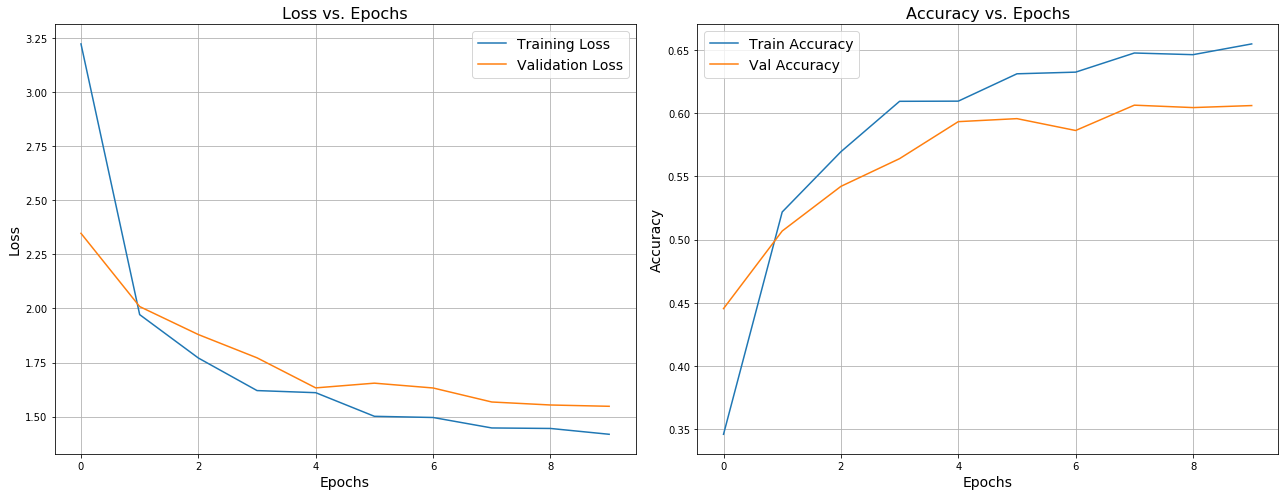

In [13]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

# 2. VGG19

In [14]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=160, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [17]:
# Load pre-trained VGG19
vgg19_base = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
vgg19 = Sequential()
vgg19.add(vgg19_base)
vgg19.add(Flatten(name='flatten'))
vgg19.add(Dense(512, activation='relu', name='fc'))
vgg19.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
vgg19_base.trainable = False

# Model summary
vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc (Dense)                   (None, 512)               12845568  
_________________________________________________________________
prediction (Dense)           (None, 128)               65664     
Total params: 32,935,616
Trainable params: 12,911,232
Non-trainable params: 20,024,384
_________________________________________________________________


In [18]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/vgg19_2_initial.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = vgg19.fit_generator(train_generator, steps_per_epoch=100, epochs=10, verbose=2, 
                              callbacks=callbacks, validation_data=val_generator, validation_steps=22)

Learning rate:  0.001
Epoch 1/10
Learning rate:  0.001
 - 223s - loss: 3.0961 - acc: 0.3264 - val_loss: 2.3947 - val_acc: 0.4007
Epoch 2/10
Learning rate:  0.001
 - 203s - loss: 1.9580 - acc: 0.5033 - val_loss: 1.9985 - val_acc: 0.4898
Epoch 3/10
Learning rate:  0.001
 - 201s - loss: 1.7237 - acc: 0.5511 - val_loss: 1.8214 - val_acc: 0.5310
Epoch 4/10
Learning rate:  0.001
 - 199s - loss: 1.5737 - acc: 0.5837 - val_loss: 1.7636 - val_acc: 0.5429
Epoch 5/10
Learning rate:  0.001
 - 212s - loss: 1.5221 - acc: 0.5896 - val_loss: 1.6937 - val_acc: 0.5609
Epoch 6/10
Learning rate:  0.001
 - 198s - loss: 1.4784 - acc: 0.6104 - val_loss: 1.6334 - val_acc: 0.5709
Epoch 7/10
Learning rate:  0.001
 - 200s - loss: 1.4007 - acc: 0.6209 - val_loss: 1.5336 - val_acc: 0.5946
Epoch 8/10
Learning rate:  0.001
 - 200s - loss: 1.3959 - acc: 0.6203 - val_loss: 1.6167 - val_acc: 0.5701
Epoch 9/10
Learning rate:  0.001
 - 201s - loss: 1.3792 - acc: 0.6294 - val_loss: 1.5532 - val_acc: 0.5784
Epoch 10/10
Lea

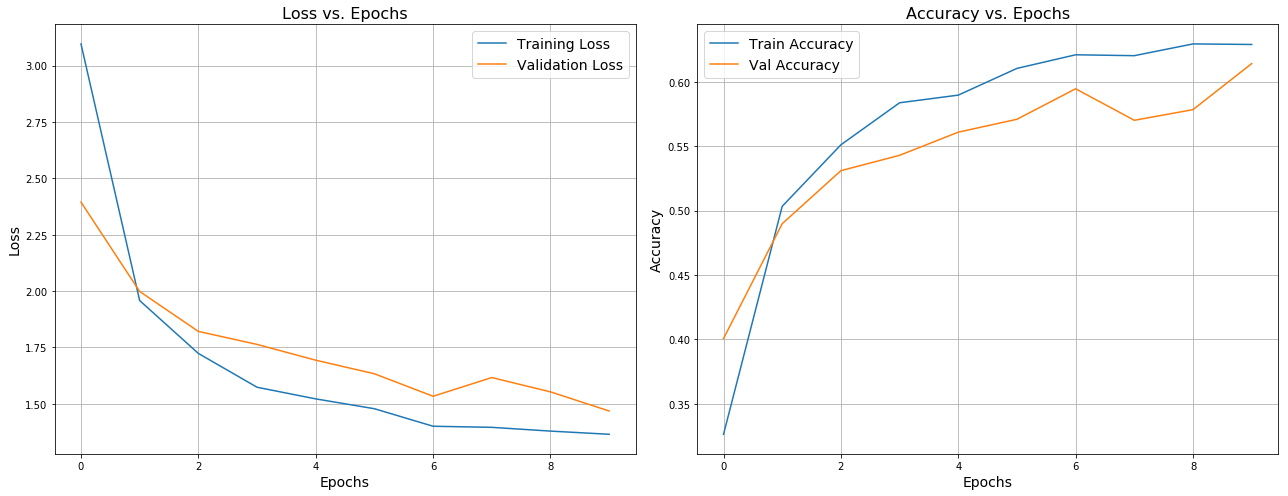

In [19]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

# 3. ResNet50

In [22]:
# For reproduciable purpose
seed = 29
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=160, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [23]:
# Load pre-trained resnet
resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
resnet = Sequential()
resnet.add(resnet_base)
resnet.add(Flatten(name='flatten'))
resnet.add(Dense(512, activation='relu', name='fc'))
resnet.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
resnet_base.trainable = False

# Model summary
resnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
fc (Dense)                   (None, 512)               1049088   
_________________________________________________________________
prediction (Dense)           (None, 128)               65664     
Total params: 24,702,464
Trainable params: 1,114,752
Non-trainable params: 23,587,712
_________________________________________________________________


In [24]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
resnet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/resnet_2_initial.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = resnet.fit_generator(train_generator, steps_per_epoch=100, epochs=10, verbose=2, 
                               callbacks=callbacks, validation_data=val_generator, validation_steps=22)

Learning rate:  0.001
Epoch 1/10
Learning rate:  0.001
 - 217s - loss: 2.3919 - acc: 0.4324 - val_loss: 5.6648 - val_acc: 0.0081
Epoch 2/10
Learning rate:  0.001
 - 197s - loss: 1.5011 - acc: 0.5929 - val_loss: 6.1350 - val_acc: 0.0087
Epoch 3/10
Learning rate:  0.001
 - 197s - loss: 1.3685 - acc: 0.6265 - val_loss: 6.0838 - val_acc: 0.0081
Epoch 4/10
Learning rate:  0.001
 - 196s - loss: 1.2765 - acc: 0.6424 - val_loss: 6.4302 - val_acc: 0.0079
Epoch 5/10
Learning rate:  0.001
 - 198s - loss: 1.2049 - acc: 0.6689 - val_loss: 6.6930 - val_acc: 0.0060
Epoch 6/10
Learning rate:  0.001
 - 197s - loss: 1.1892 - acc: 0.6649 - val_loss: 7.0319 - val_acc: 0.0078
Epoch 7/10
Learning rate:  0.001
 - 198s - loss: 1.1454 - acc: 0.6774 - val_loss: 6.8799 - val_acc: 0.0078
Epoch 8/10
Learning rate:  0.001
 - 196s - loss: 1.1262 - acc: 0.6768 - val_loss: 6.8647 - val_acc: 0.0078
Epoch 9/10
Learning rate:  0.001
 - 196s - loss: 1.0946 - acc: 0.6892 - val_loss: 7.2499 - val_acc: 0.0060
Epoch 10/10
Lea

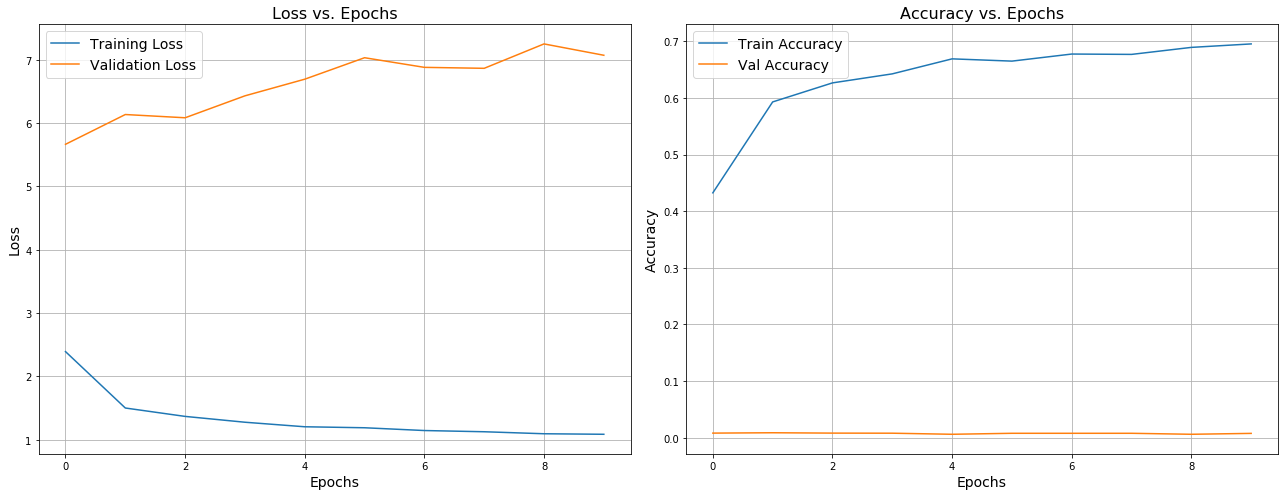

In [25]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

# 4. InceptionV3

In [26]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=160, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [27]:
# Load pre-trained InceptionV3
inception_base = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
inception = Sequential()
inception.add(inception_base)
inception.add(Flatten(name='flatten'))
inception.add(Dense(512, activation='relu', name='fc'))
inception.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
inception_base.trainable = False

# Model summary
inception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
fc (Dense)                   (None, 512)               26214912  
_________________________________________________________________
prediction (Dense)           (None, 128)               65664     
Total params: 48,083,360
Trainable params: 26,280,576
Non-trainable params: 21,802,784
_________________________________________________________________


In [28]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
inception.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/inception_2_initial.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = inception.fit_generator(train_generator, steps_per_epoch=100, epochs=10, verbose=2, 
                                  callbacks=callbacks, validation_data=val_generator, validation_steps=22)

Learning rate:  0.001
Epoch 1/10
Learning rate:  0.001
 - 218s - loss: 9.3773 - acc: 0.2207 - val_loss: 9.3433 - val_acc: 0.2430
Epoch 2/10
Learning rate:  0.001
 - 214s - loss: 4.0173 - acc: 0.2994 - val_loss: 4.0328 - val_acc: 0.3206
Epoch 3/10
Learning rate:  0.001
 - 196s - loss: 2.3119 - acc: 0.4428 - val_loss: 3.6737 - val_acc: 0.3541
Epoch 4/10
Learning rate:  0.001
 - 198s - loss: 2.0382 - acc: 0.4875 - val_loss: 3.2300 - val_acc: 0.4002
Epoch 5/10
Learning rate:  0.001
 - 195s - loss: 1.8986 - acc: 0.5088 - val_loss: 2.9274 - val_acc: 0.4189
Epoch 6/10
Learning rate:  0.001
 - 196s - loss: 1.8083 - acc: 0.5296 - val_loss: 2.7680 - val_acc: 0.4283
Epoch 7/10
Learning rate:  0.001
 - 196s - loss: 1.7348 - acc: 0.5476 - val_loss: 2.7038 - val_acc: 0.4288
Epoch 8/10
Learning rate:  0.001
 - 215s - loss: 1.6620 - acc: 0.5638 - val_loss: 2.6451 - val_acc: 0.4394
Epoch 9/10
Learning rate:  0.001
 - 196s - loss: 1.6595 - acc: 0.5540 - val_loss: 2.6548 - val_acc: 0.4525
Epoch 10/10
Lea

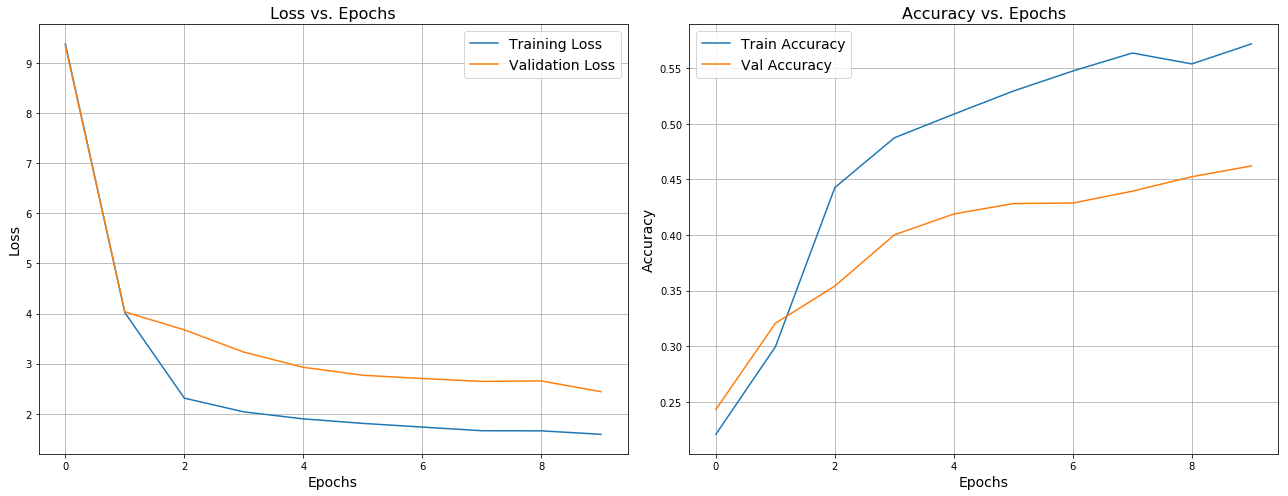

In [29]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

# 5. Xception

In [30]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=160, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [31]:
# Load pre-trained Xception
xception_base = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
xception = Sequential()
xception.add(xception_base)
xception.add(Flatten(name='flatten'))
xception.add(Dense(512, activation='relu', name='fc'))
xception.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
xception_base.trainable = False

# Model summary
xception.summary()

83689472/83683744 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
fc (Dense)                   (None, 512)               51380736  
_________________________________________________________________
prediction (Dense)           (None, 128)               65664     
Total params: 72,307,880
Trainable params: 51,446,400
Non-trainable params: 20,861,480
_________________________________________________________________


In [32]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
xception.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/xception_2_initial.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = xception.fit_generator(train_generator, steps_per_epoch=100, epochs=10, verbose=2, 
                                 callbacks=callbacks, validation_data=val_generator, validation_steps=22)

Learning rate:  0.001
Epoch 1/10
Learning rate:  0.001
 - 230s - loss: 4.1200 - acc: 0.3500 - val_loss: 3.3618 - val_acc: 0.3889
Epoch 2/10
Learning rate:  0.001
 - 203s - loss: 2.0295 - acc: 0.5149 - val_loss: 2.6277 - val_acc: 0.4460
Epoch 3/10
Learning rate:  0.001
 - 198s - loss: 1.8121 - acc: 0.5463 - val_loss: 2.5749 - val_acc: 0.4518
Epoch 4/10
Learning rate:  0.001
 - 195s - loss: 1.6445 - acc: 0.5723 - val_loss: 2.3665 - val_acc: 0.4733
Epoch 5/10
Learning rate:  0.001
 - 195s - loss: 1.5725 - acc: 0.5883 - val_loss: 2.3055 - val_acc: 0.4954
Epoch 6/10
Learning rate:  0.001
 - 195s - loss: 1.5226 - acc: 0.6064 - val_loss: 2.3640 - val_acc: 0.4760
Epoch 7/10
Learning rate:  0.001
 - 196s - loss: 1.4901 - acc: 0.6081 - val_loss: 2.2715 - val_acc: 0.4755
Epoch 8/10
Learning rate:  0.001
 - 196s - loss: 1.4402 - acc: 0.6181 - val_loss: 2.2051 - val_acc: 0.4843
Epoch 9/10
Learning rate:  0.001
 - 196s - loss: 1.4101 - acc: 0.6173 - val_loss: 2.2291 - val_acc: 0.4898
Epoch 10/10
Lea

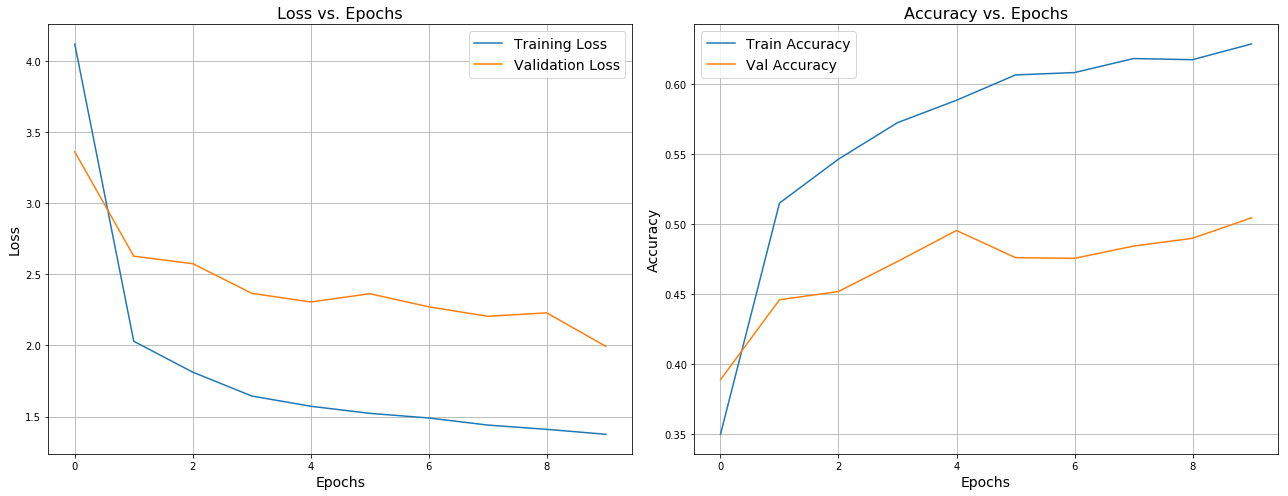

In [33]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

# 6. DenseNet121

In [34]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=160, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [35]:
# Load pre-trained DenseNet121
densenet_base = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
densenet = Sequential()
densenet.add(densenet_base)
densenet.add(Flatten(name='flatten'))
densenet.add(Dense(512, activation='relu', name='fc'))
densenet.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
densenet_base.trainable = False

# Model summary
densenet.summary()

30015488/30011760 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
fc (Dense)                   (None, 512)               25690624  
_________________________________________________________________
prediction (Dense)           (None, 128)               65664     
Total params: 32,793,792
Trainable params: 25,756,288
Non-trainable params: 7,037,504
_________________________________________________________________


In [36]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
densenet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/densenet_2_initial.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = densenet.fit_generator(train_generator, steps_per_epoch=100, epochs=10, verbose=2, 
                                 callbacks=callbacks, validation_data=val_generator, validation_steps=22)

Learning rate:  0.001
Epoch 1/10
Learning rate:  0.001
 - 235s - loss: 2.4917 - acc: 0.4678 - val_loss: 2.4689 - val_acc: 0.4518
Epoch 2/10
Learning rate:  0.001
 - 209s - loss: 1.7050 - acc: 0.5848 - val_loss: 2.2404 - val_acc: 0.4933
Epoch 3/10
Learning rate:  0.001
 - 210s - loss: 1.5133 - acc: 0.6180 - val_loss: 2.2252 - val_acc: 0.4903
Epoch 4/10
Learning rate:  0.001
 - 212s - loss: 1.3805 - acc: 0.6534 - val_loss: 2.2381 - val_acc: 0.5037
Epoch 5/10
Learning rate:  0.001
 - 207s - loss: 1.3727 - acc: 0.6496 - val_loss: 1.9963 - val_acc: 0.5289
Epoch 6/10
Learning rate:  0.001
 - 198s - loss: 1.2645 - acc: 0.6660 - val_loss: 1.9370 - val_acc: 0.5413
Epoch 7/10
Learning rate:  0.001
 - 197s - loss: 1.2357 - acc: 0.6756 - val_loss: 1.9248 - val_acc: 0.5456
Epoch 8/10
Learning rate:  0.001
 - 197s - loss: 1.2063 - acc: 0.6794 - val_loss: 1.8830 - val_acc: 0.5462
Epoch 9/10
Learning rate:  0.001
 - 198s - loss: 1.1841 - acc: 0.6816 - val_loss: 1.7650 - val_acc: 0.5655
Epoch 10/10
Lea

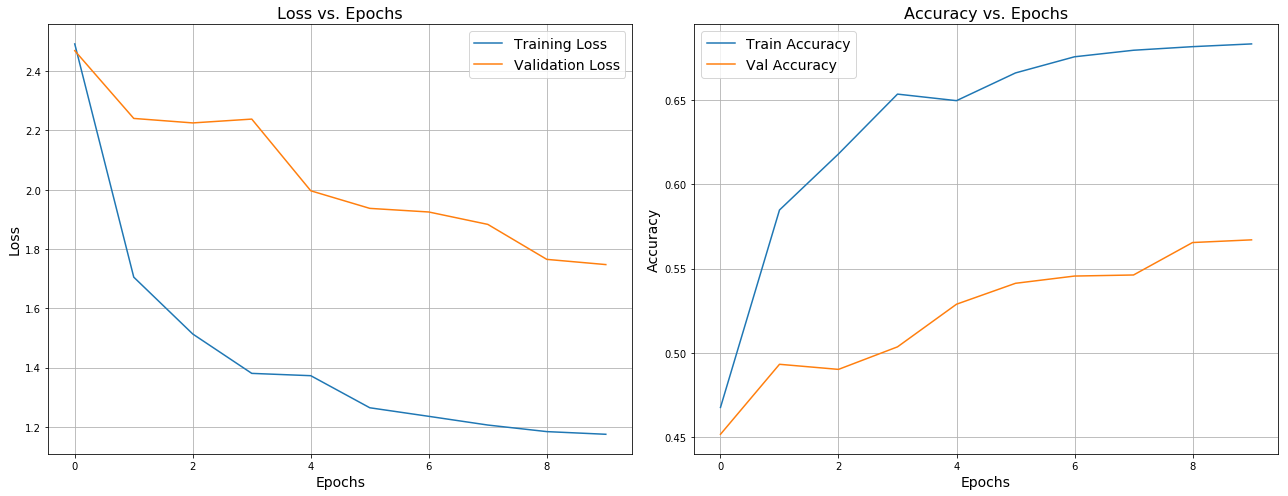

In [37]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

# Make Predictions

### Load test images

In [38]:
# # Load test images
# test_ids = []
# test_images = []
# for idx in test_df['id'].values:
#     if os.path.exists('./data/test/' + str(idx) + '.jpg'):
#         img = Image.open('./data/test/' + str(idx) + '.jpg')
#         if img.mode != 'RGB':
#             img = img.convert('RGB')
#         img = img.resize((224, 224))
#         img = np.asarray(img, dtype=K.floatx())
#         test_images.append(img)
#         test_ids.append(idx)

# # Re-scale the images
# test_images = np.array(test_images, dtype=K.floatx())
# test_images = test_images / 255.0

### 1. VGG16

In [39]:
# # Load the saved model
# vgg16 = load_model('./models/vgg16_2_initial.h5')

# # Make predictions
# test_pred = vgg16.predict(test_images)
# test_label = np.argmax(test_pred, axis=1) + 1

# # Sample submission
# sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
# df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# # Merge together
# df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# # Fill missing values
# n = df_submission['predicted'].isnull().sum()
# guess = np.random.choice(range(1, 129), n, replace=True)
# df_submission[df_submission['predicted'].isnull()]['predicted'] = guess

# # Save to disk
# df_submission.to_csv('./result/vgg16_2_initial.csv', columns=['id', 'predicted'], index=False)

### 2. VGG19

In [40]:
# # Load the saved model
# vgg19 = load_model('./models/vgg19_2_initial.h5')

# # Make predictions
# test_pred = vgg19.predict(test_images)
# test_label = np.argmax(test_pred, axis=1) + 1

# # Sample submission
# sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
# df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# # Merge together
# df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# # Fill missing values
# n = df_submission['predicted'].isnull().sum()
# guess = np.random.choice(range(1, 129), n, replace=True)
# df_submission[df_submission['predicted'].isnull()]['predicted'] = guess

# # Save to disk
# df_submission.to_csv('./result/vgg19_2_initial.csv', columns=['id', 'predicted'], index=False)

### 3. ResNet50

In [41]:
# # Load the saved model
# resnet = load_model('./models/resnet_2_initial.h5')

# # Make predictions
# test_pred = resnet.predict(test_images)
# test_label = np.argmax(test_pred, axis=1) + 1

# # Sample submission
# sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
# df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# # Merge together
# df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# # Fill missing values
# n = df_submission['predicted'].isnull().sum()
# guess = np.random.choice(range(1, 129), n, replace=True)
# df_submission[df_submission['predicted'].isnull()]['predicted'] = guess

# # Save to disk
# df_submission.to_csv('./result/resnet_2_initial.csv', columns=['id', 'predicted'], index=False)

### 4. InceptionV3

In [42]:
# # Load the saved model
# inception = load_model('./models/inception_2_initial.h5')

# # Make predictions
# test_pred = inception.predict(test_images)
# test_label = np.argmax(test_pred, axis=1) + 1

# # Sample submission
# sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
# df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# # Merge together
# df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# # Fill missing values
# n = df_submission['predicted'].isnull().sum()
# guess = np.random.choice(range(1, 129), n, replace=True)
# df_submission[df_submission['predicted'].isnull()]['predicted'] = guess

# # Save to disk
# df_submission.to_csv('./result/inception_2_initial.csv', columns=['id', 'predicted'], index=False)

### 5. Xception

In [43]:
# # Load the saved model
# xception = load_model('./models/xception_2_initial.h5')

# # Make predictions
# test_pred = xception.predict(test_images)
# test_label = np.argmax(test_pred, axis=1) + 1

# # Sample submission
# sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
# df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# # Merge together
# df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# # Fill missing values
# n = df_submission['predicted'].isnull().sum()
# guess = np.random.choice(range(1, 129), n, replace=True)
# df_submission[df_submission['predicted'].isnull()]['predicted'] = guess

# # Save to disk
# df_submission.to_csv('./result/xception_2_initial.csv', columns=['id', 'predicted'], index=False)

### 6. DenseNet121

In [44]:
# # Load the saved model
# densenet = load_model('./models/densenet_2_initial.h5')

# # Make predictions
# test_pred = densenet.predict(test_images)
# test_label = np.argmax(test_pred, axis=1) + 1

# # Sample submission
# sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
# df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# # Merge together
# df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# # Fill missing values
# n = df_submission['predicted'].isnull().sum()
# guess = np.random.choice(range(1, 129), n, replace=True)
# df_submission[df_submission['predicted'].isnull()]['predicted'] = guess

# # Save to disk
# df_submission.to_csv('./result/densenet_2_initial.csv', columns=['id', 'predicted'], index=False)